# Emojify! 

We are going to use word vector representations to build an Emojifier. 

Have you ever wanted to make your text messages more expressive? This emojifier app will help do that. So rather than writing "Congratulations on the promotion! Lets get coffee and talk. Love you!" the emojifier can automatically turn this into "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

We will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️). In many emoji interfaces, remember that ❤️ is the "heart" symbol rather than the "love" symbol. But using word vectors, we'll see that even if your training set explicitly relates only a few words to a particular emoji, our algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows us to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

We'll start with a baseline model (Emojifier-V1) using word embeddings, then build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

Lets get started!.

In [1]:
# Importing our dependencies
import numpy as np
import emoji
import matplotlib.pyplot as plt
import pandas as pd
from emoji_utils import *

%matplotlib inline

## 1 - Baseline model: Emojifier-V1

### 1.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier. 

We have a tiny dataset (X, Y) where:
- X contains 132 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence

<img src="images/data_set.png" style="width:700px;height:300px;">
<caption><center> **Figure 1**: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

- We split the dataset between training (132 examples) and testing (56 examples).

In [2]:
X_train, Y_train = read_csv_file('data/train_emoji.csv')
X_test, Y_test = read_csv_file('data/test_emoji.csv')

print("Number of training examples : ",X_train.shape[0])
print("Number of testing examples : ",X_test.shape[0])

Number of training examples :  132
Number of testing examples :  56


In [3]:
# Here length of largest phrase will be the max length of any input sentence
largest_phrase = max(X_train, key=len)
maxLen = len(largest_phrase.split())
print("Length of largest phrase   : ", maxLen)
print("Largest phrase in the data : ", largest_phrase)

Length of largest phrase   :  10
Largest phrase in the data :  I am so impressed by your dedication to this project


In [4]:
# Emoji's we are going to use...
print(emoji_dictionary)

for key, value in emoji_dictionary.items():
    print(key, ":", label_to_emoji(key))

{'1': ':baseball:', '0': '❤️', '3': ':disappointed:', '4': ':fork_and_knife:', '2': ':smile:'}
1 : ⚾
0 : ❤️
3 : 😞
4 : 🍴
2 : 😄


In [5]:
for i,j in zip(X_train[ :5], Y_train[ :5]):
    print(i,label_to_emoji(j))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴


### 1.2 - Overview of the Emojifier-V1

We are going to implement a baseline model called "Emojifier-v1".  

<center>
<img src="images/image_1.png" style="width:900px;height:300px;">
<caption><center> **Figure 2**: Baseline model (Emojifier-V1).</center></caption>
</center>

The input of the model is a string corresponding to a sentence (e.g. "I love you). In the code, the output will be a probability vector of shape (1,5), that we then pass in an argmax layer to extract the index of the most likely emoji output.

In [6]:
# Convert labels to one-hot vectors
Y_train_oh = one_hot(Y_train, num_classes=5)
Y_test_oh = one_hot(Y_test, num_classes=5)

index = 127
print(Y_train[index], 'is converted to one_hot', Y_train_oh[index])

1 is converted to one_hot [ 0.  1.  0.  0.  0.]


### 1.3 - Implementing Emojifier-V1

The first step is to convert an input sentence into the word vector representation, which then get averaged together. Similar to the previous exercise, we will use pretrained 50-dimensional GloVe embeddings. The following cell loads the `word_to_vec_map`, which contains all the vector representations.

In [7]:
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

print(" Number of words in Glove_data set : ", len(word_to_vec_map.keys()))
print(" Size of each vector               : ", len(word_to_vec_map['sorry']))

 Number of words in Glove_data set :  400000
 Size of each vector               :  50


In [8]:
word = 'cucumber'
print("The index of ", word, "in the vocabulary is ", words_to_index[word])
index = words_to_index[word]
print("The word at ", index, "in the vocabulary is ", index_to_words[index])

The index of  cucumber in the vocabulary is  113317
The word at  113317 in the vocabulary is  cucumber


In [9]:
def sentence_to_avg(word_to_vec_map, sentence):
    
    # strips sentences into list of lowercase words
    words = list(map(lambda word : word.lower(), sentence.split()))
    #print(words)
    
    avg = np.zeros((50, ))
    
    for word in words:
        avg += word_to_vec_map[word]
    avg = avg/len(words)
    
    return avg

In [10]:
avg = sentence_to_avg(word_to_vec_map, 'You had only one job')
print("shape of avg :", avg.shape)
print("Averaged glove vector for sentence : ", avg)

shape of avg : (50,)
Averaged glove vector for sentence :  [  1.92513620e-01   7.97070000e-02   2.72638000e-01  -2.94728000e-01
   6.41210000e-01   1.75848000e-01  -7.57188000e-01   1.34732240e-01
  -2.74310200e-01  -1.23909700e-01  -8.96100000e-02   1.46049600e-01
  -5.32302000e-01  -9.79036000e-02   8.20924000e-01   5.84444000e-02
   9.66792000e-02   9.24422000e-02  -2.97160000e-01  -6.02572000e-01
  -1.99194000e-01   3.33171600e-01   2.96942000e-01   5.15600000e-03
   3.18787200e-01  -1.86422000e+00  -4.41714000e-01   1.33376000e-02
   4.48436000e-01  -4.68292000e-01   3.57988000e+00   3.82497200e-01
  -1.93891200e-01  -2.05173200e-01   2.20312460e-01   1.04437800e-01
   2.71212000e-01   4.15665600e-01   2.65717600e-01  -3.47841600e-01
  -2.02602000e-01   1.60561000e-01  -7.72248000e-02   4.19363000e-01
  -2.07754000e-01  -1.42353600e-01  -2.44369400e-01  -5.41600000e-04
  -6.87961200e-02   3.27289200e-01]


### 1.4 Model

We now have all the pieces to finish implementing the `model()` function. After using `sentence_to_avg()` We need to pass the average through forward propagation, compute the cost, and then backpropagate to update the softmax's parameters. 

Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations needed to implement in the forward pass and to compute the cross-entropy cost are:
$$ z^{(i)} = W . avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

It is possible to come up with a more efficient vectorized implementation. But since we are using a for-loop to convert the sentences one at a time into the avg^{(i)} representation anyway.

In [11]:
def model(X, Y, word_to_vec_map, num_iterations =400, learning_rate = 0.01):
    
    m = Y.shape[0]
    
    n_y = 5
    n_h = 50  #Hidden layers
    
    # Random initialization of weights and biases
    W = np.random.randn(n_y, n_h)/ np.sqrt(n_h)
    b = np.random.randn(n_y, )
    
    Y_oh = one_hot(Y, n_y)
    
    for t in range(num_iterations):    #loop over number of iterations
        for i in range(m):             #loop over number of examples
            
            # Forward propagation
            avg = sentence_to_avg(word_to_vec_map, X[i])   # avg vector for each sentence
            Z  = np.matmul(W, avg) + b                     # Dot product
            A = softmax(Z)
            
            assert(A.shape == (W.shape[0], ))
            
            # Logistic loss
            cost = -(np.sum(Y_oh[i] * np.log(A)))         
            
            # Backward propagation
            dz = A - Y_oh[i]
            dw = np.matmul(dz.reshape(n_y, 1), avg.reshape(1, n_h))
            db = dz
            
            assert(dw.shape == W.shape)
            
            # Updating parameters
            W = W - learning_rate * dw
            b = b - learning_rate * db
            
            # Print Acuuracy
        if (t % 100 == 0) or (t == num_iterations - 1):
            print("Epoch    : " + str(t) + "\nCost     : %f"%(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)
            print("-"*35)
        
    return pred, W, b        

In [12]:
pred_train, W, b = model(X_train, Y_train, word_to_vec_map, num_iterations=1200)

Epoch    : 0
Cost     : 1.747688
Accuracy : 0.378788
-----------------------------------
Epoch    : 100
Cost     : 0.076308
Accuracy : 0.871212
-----------------------------------
Epoch    : 200
Cost     : 0.046902
Accuracy : 0.893939
-----------------------------------
Epoch    : 300
Cost     : 0.037510
Accuracy : 0.901515
-----------------------------------
Epoch    : 400
Cost     : 0.032189
Accuracy : 0.901515
-----------------------------------
Epoch    : 500
Cost     : 0.028492
Accuracy : 0.909091
-----------------------------------
Epoch    : 600
Cost     : 0.025679
Accuracy : 0.909091
-----------------------------------
Epoch    : 700
Cost     : 0.023427
Accuracy : 0.909091
-----------------------------------
Epoch    : 800
Cost     : 0.021570
Accuracy : 0.916667
-----------------------------------
Epoch    : 900
Cost     : 0.020008
Accuracy : 0.916667
-----------------------------------
Epoch    : 1000
Cost     : 0.018678
Accuracy : 0.916667
-----------------------------------


Great! Our model has pretty high accuracy on the training set. Lets now see how it does on the test set. 

In [13]:
print("Test Set ")
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Test Set 
Accuracy : 0.892857


* Random guessing would have had 20% accuracy given that there are 5 classes. This is pretty good performance after training on only 132 examples. 

* In the training set, the algorithm saw the sentence "*I love you*" with the label ❤️. You can check however that the word "adore" does not appear in the training set. Nonetheless, lets see what happens if you write "*I adore you*."



In [14]:
X_my_sentences = np.array(['Come on lets play', 'you are such a nasty fellow', 'all the negative reviews vanished',
                           'I adore you', 'there were no pizzas left', 'Had your dinner ?', 'not feeling happy',
                          'the movie is not good and not enjoyable'])

Y_my_labels = np.array([[1], [3], [2], [0], [3], [4], [3], [3]], dtype=np.float32)


my_preds = predict(X_my_sentences, Y_my_labels, W, b, word_to_vec_map)
print("\npredictions : ", my_preds.flatten(), "\ntrue labels : ", Y_my_labels.flatten())
print("\n ************** predicted emoji's for our input sentences ****************")
print_predictions(X_my_sentences, my_preds)

Accuracy : 0.500000

predictions :  [ 1.  3.  3.  0.  3.  0.  2.  2.] 
true labels :  [ 1.  3.  2.  0.  3.  4.  3.  3.]

 ************** predicted emoji's for our input sentences ****************

Come on lets play ⚾
you are such a nasty fellow 😞
all the negative reviews vanished 😞
I adore you ❤️
there were no pizzas left 😞
Had your dinner ? ❤️
not feeling happy 😄
the movie is not good and not enjoyable 😄


* Amazing! Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*, and so might work too.

* Note though that it doesn't get `not feeling happy`, `Had your dinner?`, `all the negative reviews vanished`,
`the movie is not good and not enjoyable` correct. This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

* Printing the confusion matrix can also help understand which classes are more difficult for your model. A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class). 




           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
True                                   
0            7    0    0    0    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            2    0    1   13    0   16
4            1    0    0    0    6    7
All         12    8   17   13    6   56


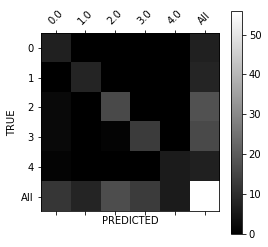

In [15]:
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))


print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['True'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

### 1.5 Mislabelled Sentences

* Let's look at some of the false predictions made by our model

In [17]:
mislabelled_indices = print_mislabelled_sentences(X_test, Y_test, pred_test)

   True   : work is hard	 😞
Predicted : work is hard	 😄
---------------------------------------
   True   : you brighten my day	 😄
Predicted : you brighten my day	 ❤️
---------------------------------------
   True   : she is a bully	 😞
Predicted : she is a bully	 ❤️
---------------------------------------
   True   : My life is so boring	 😞
Predicted : My life is so boring	 ❤️
---------------------------------------
   True   : will you be my valentine	 😄
Predicted : will you be my valentine	 ❤️
---------------------------------------
   True   : I did not have breakfast  🍴
Predicted : I did not have breakfast  ❤️
---------------------------------------


**Observations** :
* We used a plain Network to predict emotions of our sentences.
* Only a single layer with 50 hidden units is used and, we achieved 90% accuracy which is pretty good.
* If you look at the errors our model made... ❤️hearts appear to be more.

<font color='blue'>
**What we should remember from this part**:
- Even with a few training examples, we can get a reasonably good model for Emojifying. This is due to the generalization power word vectors gives you. 
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"* because it doesn't understand combinations of words--it just averages all the words' embedding vectors together, without paying attention to the ordering of words. We will build a better algorithm in the next part.
    
<font color='green'>
    ** Next let's implement Emojifier-V2 using LSTM Networks**


### References 

This notebook uses the GloVe algorithm due to Jeffrey Pennington, Richard Socher, and Christopher D. Manning.(2014)

- Jeffrey Pennington, Richard Socher, and Christopher D. Manning- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)
- Stanford NLP (https://nlp.stanford.edu/projects/glove/)
